# Pre-Processing Workflow
As a rule, if any pre-processing is to be done on the samples I prefer to do it prior to training and to store the pre-processed data separately. For a fully trained model it is better to run the transformers in the normal manner, but during training it adds unnecessarily to runtime, as the pre-processing is applied every epoch.

Still, this creates some inflexibility, as tuning the pre-processing steps becomes far more tedious.

My solution is to run hyper-parameter tuning on a small batch of the data using a toy model, evaluate that model's success via cross-validation, and then use those values to pre-process the entire dataset.

Obviously even the above would be useless without a general sense of what techniques should be applied to what kinds of data.

In [ ]:
%load_ext autoreload
%autoreload 2

import sys; sys.path.append('./*'); sys.path.append('..')

import torch
import torch.nn as nn
from torchvision.transforms import v2
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from os import path
from trainer import Trainer
import pandas as pd

torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d = '../sheet_data'

In [14]:
from datasets.ClassificationSet import ClassificationSet
from models.SheetClassifier import SheetClassifier

# Load the dataset
full_data = pd.read_csv(f'{path.join(d, "training_set")}/metadata.csv')
dummy_parameters = SheetClassifier().state_dict()
trainer = Trainer()

# from sklearn.model_selection import StratifiedShuffleSplit would have given us the same distrobution as the original
train_set, test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.3, test_size=.2, random_state=0, stratify=full_data.target)
train_set['target'] = y_train; test_set['target'] = y_test

# Show levels of targets are equivalent
print('Bubbles to Line in Training',round(len(y_train[y_train == 1])/len(y_train[y_train == 2]),2))
print('Bubbles to Line in Testing',round(len(y_test[y_test == 1])/len(y_test[y_test == 2]),2))

Bubbles to Line in Training 0.95
Bubbles to Line in Testing 0.95


In [15]:
import optuna

#====
epochs = 10
show = False
#====
results = pd.DataFrame([], columns=['blur_value', 'norm_mean', 'norm_std', 'accuracy', 'loss'])

def objective(trial, gaussian_blur:int=None, norm_mean:float=None, norm_std:float=None, record:bool=True, show:bool=False):
    gaussian_blur = trial.suggest_int('gaussian_blur', 1, 5, step=2) if not gaussian_blur else gaussian_blur
    norm_mean = trial.suggest_float('norm_mean', -.9, .9) if not norm_mean else norm_mean
    norm_std = trial.suggest_float('norm_std', .01, .9) if not norm_std else norm_std

    transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(gaussian_blur),
                v2.Normalize([norm_mean], [norm_std], inplace=True),
                ]
            )
    c_train = ClassificationSet(path.join(d, 'training_set'), train_set, transform)
    c_test = ClassificationSet(path.join(d, 'training_set'), test_set, transform)

    temp_model = SheetClassifier()
    temp_model.load_state_dict(dummy_parameters)

    trainer.run_experiment(temp_model, c_train, c_test, criterion=nn.CrossEntropyLoss, epochs=epochs, show=show, train_shuffle=False, test_shuffle=False)
    trainer.evaluate_model(temp_model, show=show)

    if record: results.loc[len(results)] = [gaussian_blur, norm_mean, norm_std, trainer.model_accuracy, trainer.model_loss]
    return trainer.model_accuracy

In [16]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)

[I 2025-03-12 14:38:24,791] A new study created in memory with name: no-name-16a26653-9875-4c59-a79f-99866fc8cc1e
[I 2025-03-12 14:38:29,632] Trial 0 finished with value: 0.7724999785423279 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.387340859470355, 'norm_std': 0.5464594047037631}. Best is trial 0 with value: 0.7724999785423279.
[I 2025-03-12 14:38:34,434] Trial 1 finished with value: 0.7549999952316284 and parameters: {'gaussian_blur': 3, 'norm_mean': -0.1374213611899715, 'norm_std': 0.5848457606293239}. Best is trial 0 with value: 0.7724999785423279.
[I 2025-03-12 14:38:39,228] Trial 2 finished with value: 0.7824999690055847 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.7051914014077435, 'norm_std': 0.8676598568459161}. Best is trial 2 with value: 0.7824999690055847.
[I 2025-03-12 14:38:44,167] Trial 3 finished with value: 0.7350000143051147 and parameters: {'gaussian_blur': 3, 'norm_mean': 0.5251050685487962, 'norm_std': 0.480716478580085}. Best is trial 2 with value:

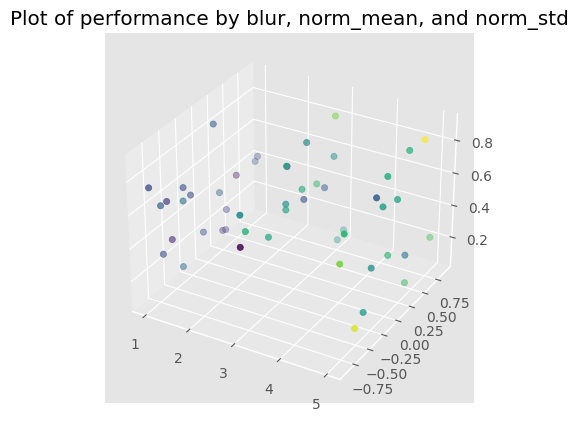

In [17]:
# importing mplot3d toolkits, numpy and matplotlib
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
# defining all 3 axis
 
# plotting
ax.scatter(results.blur_value, results.norm_mean, results.norm_std, c=results.accuracy)
ax.set_title('Plot of performance by blur, norm_mean, and norm_std')
plt.show()

C:\Users\slayt\AppData\Local\Temp\ipykernel_17696\3552502145.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)
C:\Users\slayt\AppData\Local\Temp\ipykernel_17696\3552502145.py:2: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)
C:\Users\slayt\AppData\Local\Temp\ipykernel_17696\3552502145.py:3: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_slice(study, params=['gaussian_blur', 'norm_mean', 'norm_std'])
C:\Users\slayt\AppData\Local\Temp\ipykernel_17696\3552502145.py:4: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  o

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

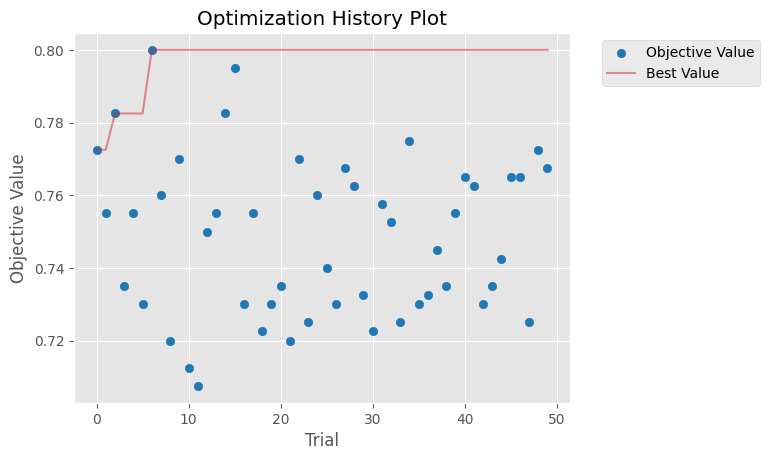

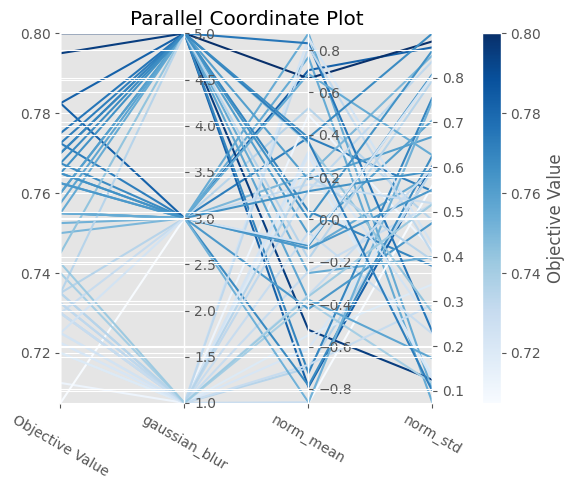

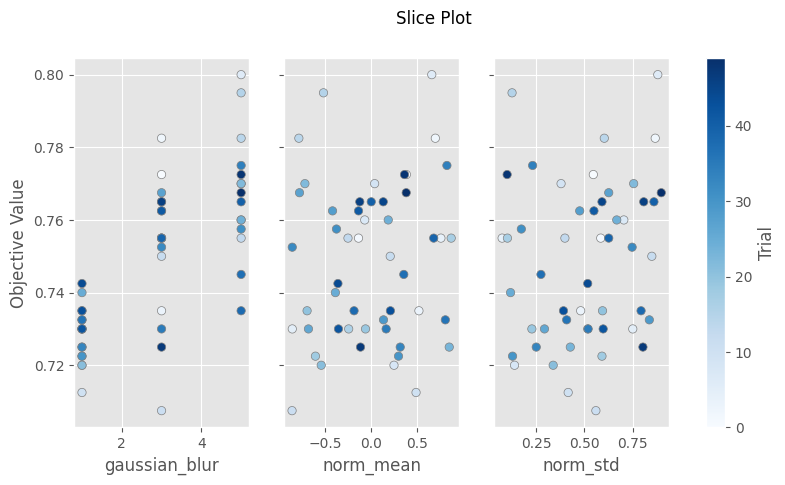

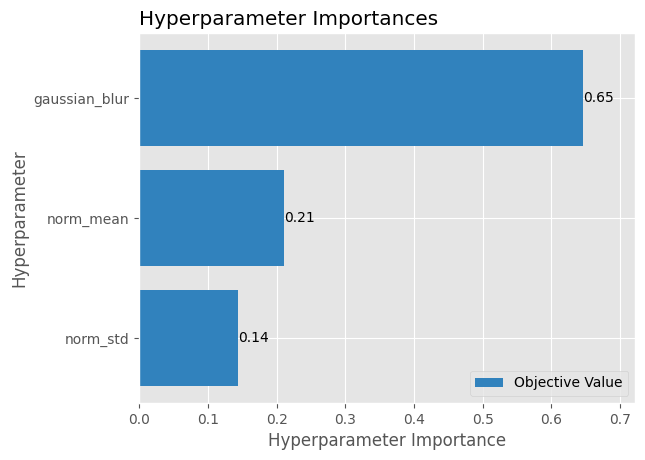

In [18]:
optuna.visualization.matplotlib.plot_optimization_history(study)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
optuna.visualization.matplotlib.plot_slice(study, params=['gaussian_blur', 'norm_mean', 'norm_std'])
optuna.visualization.matplotlib.plot_param_importances(study)

In [19]:
# Choose best and worst parameters and prep full run
best = results.sort_values('accuracy')[::-1][:3]
worst = results.sort_values('accuracy')[:3]
print('Best Performers',best,'\n\nWorst Performers',worst)

eval_train_set, eval_test_set, y_train, y_test = train_test_split(full_data, full_data.target, train_size=.8, random_state=0, stratify=full_data.target)
eval_train_set['target'] = y_train; eval_test_set['target'] = y_test

Best Performers     blur_value  norm_mean  norm_std        accuracy      loss
6            5   0.666022  0.880970  tensor(0.8000)  3.086658
15           5  -0.521311  0.124744  tensor(0.7950)  3.408491
2            3   0.705191  0.867660  tensor(0.7825)  3.716284 

Worst Performers     blur_value  norm_mean  norm_std        accuracy      loss
11           3  -0.866178  0.559696  tensor(0.7075)  4.126764
10           1   0.493621  0.415974  tensor(0.7125)  3.158160
8            1   0.251858  0.137584  tensor(0.7200)  3.263755


In [20]:
# Training a full run on the best
entry = best.iloc[0]
print(entry)
objective(None, entry.blur_value, entry.norm_mean, entry.norm_std, record=False, show=True)

blur_value                 5
norm_mean           0.666022
norm_std             0.88097
accuracy      tensor(0.8000)
loss                3.086658
Name: 6, dtype: object
Epoch [1/10], Train Loss: 7.41, Accuracy: 0.55
Epoch [6/10], Train Loss: 0.76, Accuracy: 0.92
Experiment Complete
[Evaluation over 4 Batches], Test Loss: 4.73, Accuracy: 0.69


tensor(0.6900)

In [21]:
# Training a full run on the best
entry = worst.iloc[0]
print(entry)
objective(None, entry.blur_value, entry.norm_mean, entry.norm_std, record=False, show=True)

blur_value                 3
norm_mean          -0.866178
norm_std            0.559696
accuracy      tensor(0.7075)
loss                4.126764
Name: 11, dtype: object
Epoch [1/10], Train Loss: 7.34, Accuracy: 0.53
Epoch [6/10], Train Loss: 0.20, Accuracy: 0.97
Experiment Complete
[Evaluation over 4 Batches], Test Loss: 3.41, Accuracy: 0.77


tensor(0.7675)

### Our Best Pre-Processed Samples Outperformed our Worst by 10% Accuracy
Note, it looks like the lowest values tended to have the least blur, and further, that those parameters did well in the training but poorely in testing, this is a classic example of overfitting, and another reason why this much care in the pre-processing phase *matters*.

## Apply the Best Transformer to the Data as a Pre-processing Step

In [22]:
transfer_dir = '../sheet_data/preprocessed_training_set'
entry = best.iloc[0]
transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std], inplace=True)
                ])
preprocess_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocess_set.transform_pass(transfer_dir, delete_prior_contents=True)

## Test the Speed of Training Between Preprocessed and On Call Processed
Now that we see the accuracy benefit of finding the best pre-processed settings, let's finally look at the speed benefit of applying the pre-processing to saved samples over oncall loading.

In [23]:
dpre_processed = '../sheet_data/preprocessed_training_set'
model = SheetClassifier()
model.load_state_dict(dummy_parameters)

transform = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                v2.GaussianBlur(entry.blur_value),
                v2.Normalize([entry.norm_mean], [entry.norm_std])
                ])
normal_set = ClassificationSet(path.join(d, 'training_set'), transform=transform)
preprocessed_dataset = ClassificationSet(dpre_processed)

In [24]:
trainer.evaluate_model(model, DataLoader(normal_set, 10))

[Evaluation over 200 Batches], Test Loss: 12.35, Accuracy: 0.32


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

In [25]:
trainer.evaluate_model(model, DataLoader(preprocessed_dataset, 10))

[Evaluation over 200 Batches], Test Loss: 12.19, Accuracy: 0.32


SheetClassifier(
  (model): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin1): Linear(in_features=16384, out_features=3, bias=True)
)

## Results
As we can see, using the pre-processed dataset takes 20% of the time of the non-preprocessed set (2s vs 10s), as shown above.